# Tuto\#6 Use NPE to infer the self-calibration null depth
Neural Posterior Estimation is a method where a neural network (also called a normalising flow) is trained to represent the Bayesian posterior of a dataset.
The network is trained on pairs o simulated data and their corresponding parameters; then, it is used to infer the parameters from real data.
While the training can take some time and ressources, the inference is very fast.

In this tutorial, we will see how to use GRIP's features of NPE to infer the parameters from an LBTI dataset and its histogram.

Like in the previous tutorials, we are going to infer three parameters:
- $N_A$: the self-calibrated null depth
- $\mu_{OPD}$: the average value of the OPD of the phase fluctuations
- $\sigma_{OPD}$: the standard deviation of the OPD of the phase fluctuations

$N_A$ is a deterministic value while $\mu_{OPD}$ and $\sigma_{OPD}$ parametrise a Normal distribution.

## Before starting
GRIP's NPE relies on the package LAMPE, which also relies on PyTorch. These pakages are not installed with GRIP, the installation has to be done manually.
If LAMPE and PyTorch are not installed, NPE features will not be available.

## Let's start
We start with importing the packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as time
import os
import sys
import grip
import corner
from datetime import datetime

Then we specify the directories and the parameters of the Monte-Carlo simulation

In [2]:
datafolder = 'dataset/'
darkfolder = datafolder

# Lower bound of the bandwidth to process
wl_min = 11000
# Upper bound of the bandwidth to process
wl_max = 11200
spec_chan_width = 2600
n_samp_total = int(1e5)
n_samp_per_loop = int(1e5)
nloop = n_samp_total // n_samp_per_loop

param_label = ['deterministic', 'normal1', 'normal1'] # Nature of the parameters to infer
N_BINS = 30 # Number of bins of the histograms

We load the data

In [3]:
dark_list = [datafolder+'UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5']
data_list = [datafolder+'UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5']
dark = grip.load_data(dark_list, ['wl_scale', 'Iminus1', 'p1', 'p2'], (wl_min, wl_max), 'hdf5')
data = grip.load_data(data_list, ['wl_scale', 'Iminus1', 'p1', 'p2', 'piston_rms'], (wl_min, wl_max), 'hdf5')

wl_scale = data['wl_scale']
dark_IA, dark_IB = dark['p1'], dark['p2']
dark_Iminus = dark['Iminus1']
Iminus = data['Iminus1']
data_IA, data_IB = data['p1'], data['p2']

Iminus = data['Iminus1']
Iplus = data_IA + data_IB + 2 * (data_IA * data_IB)**0.5
    
data_null = Iminus / Iplus

dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_BCKG.hdf5
dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5


We preprocess the data.

In [4]:
# Get the histogram
bin_bounds = (-0.005, 0.15) # Minimum and maximum values of the bins of the histogram
normed = True # Normalise the histograms

null_axis, null_pdf, null_pdf_err, sz = grip.compute_data_histogram(data_null, \
                                                          bin_bounds, \
                                           wl_scale, normed=normed, nb_bins=N_BINS)

nb_frames_binning_photometry = -1 # Bin over all the sample
injection, spectra = grip.get_injection_and_spectrum(
    data_IA, data_IB, wl_scale, (wl_min, wl_max))

injection = np.array(injection)
injection, dummy = grip.binning(
    injection, nb_frames_binning_photometry, axis=1, avg=True)


data_IA_axis, cdf_data_IA = grip.get_cdf(injection[0])
data_IB_axis, cdf_data_IB = grip.get_cdf(injection[1])

sigma_eps = data['piston_rms']
sigma_eps = np.radians(sigma_eps)
sigma_eps *= 2200 / wl_scale
sigma_eps = sigma_eps.reshape((1, -1))
sigma_eps_axis, sigma_eps_cdf = grip.get_dark_cdf(sigma_eps, wl_scale)

std_dark_Iminus = np.std(dark_Iminus)
dark_Iminus -= np.mean(dark_Iminus, 1, keepdims=True) # The model is better when the data are forced to be of average 0
    
dark_Iminus_axis, dark_Iminus_cdf = grip.get_dark_cdf(
    dark_Iminus, wl_scale)

rvu_opd = {'normal1':None} # To generate RV reproducing the statistics of the OPD fluctuations
rvu_IA = None # To generate RV reproducing the statistics of the injection of beam A
rvu_IB = None # To generate RV reproducing the statistics of the injection of beam B
rvu_bg = [None]*wl_scale.size # To generate RV reproducing the statistics of the thermal background, per spectral channel
rvu_eps = [None]*wl_scale.size # To generate RV reproducing the statistics of the fringe blurring, per spectral channel

# Embed all of the above in lists
rvus = [rvu_IA, rvu_IB, rvu_bg, rvu_eps]
cdfs = [(data_IA_axis, cdf_data_IA), (data_IB_axis, cdf_data_IB),\
        (dark_Iminus_axis, dark_Iminus_cdf), (sigma_eps_axis, sigma_eps_cdf)]

## Design of the neural network.
GRIP's NPE is implemented as a class.
The class is initialised with some information on the data.
The NN is design through a method, to ease the change of the hyperparameters without recreating a new object every time.

We are going to infer the parameters from the histograms of the data. We are using GRIP's LBTI model to make the simulation.

The model has two constants: the spectral bandwidth and the value $\pi$ (to have the destructive fringe).

The other parameters are random values, which empirical cumulative functions are passed through the NPE class.
It will pass it to the Monte-Carlo simulator via the function `grip.create_histogram_model`.
These elements are put into a list `func_args`.

This function also takes keywords about the parameters of the Monte-Carlo simulation that are found in a dictionary `func_kwargs`.

In [5]:
instrument_constants = (spec_chan_width, np.pi) # Constant of the LBTI model
func_args = [null_axis] + [param_label, wl_scale, grip.lbti_model, instrument_constants, rvu_opd, cdfs, rvus] # Arguments to pass to `grip.create_histogram_model` and `grip.lbti_model`
func_kwargs = {'n_samp_per_loop':n_samp_per_loop, 'nloop':nloop, 'normed':normed, 'verbose':False} # Keywords to pass to `grip.create_histogram_model`
gnpe = grip.GripNPE(wl_scale, grip.create_histogram_model, func_args, func_kwargs) # Create the object for the NN

## Create the training dataset
Now we create the training set.
We are going to create simulated histograms with their triplet of parameters to train the neural network by mapping from the former to the latter.

GRIP's NPE gives the choice of the prior on the parameters: uniform or Normal distribution.
The natures of the priors are put into a list.
Likewise, the parameters of these distributions are put into a list of tuples (one tuple per distribution, containing all the parameters for the corresponding distribution).
See the documentation of `grip.create_train_set` for more information.

The training dataset is shaped by the number of samples per batch and the number of batch per epoch.
The output of `gnpe.create_train_set` is a tuple of the simulated datasets and their corresponding simulated parameters.

In [6]:
distro_type = ['uniform', 'uniform', 'uniform'] # Nature of the priors Na, mu_OPD, sig_OPD

bounds_mu = (0, 1000) # Boundaries of mu opd
bounds_sig = (100, 400) # Boundaries of sig opd
bounds_na = (0.0, 0.02) # Boundaries of Na
param_bounds = [bounds_na, bounds_mu, bounds_sig]

BATCH_SIZE = 64
NB_BATCH_PER_EPOCH = 128  # number batches per epoch

train_set = gnpe.create_train_set(NB_BATCH_PER_EPOCH, BATCH_SIZE, distro_type, param_bounds)
# train_set[0].shape: (NB_BATCH_PER_EPOCH, BATCH_SIZE, N_BINS)
# train_set[1].shape: (NB_BATCH_PER_EPOCH, BATCH_SIZE, NB_PARAMETERS)

100%|██████████| 128/128 [00:51<00:00,  2.50it/s]


## Create and train the NN
LAMPE designs a neural network with the following parameters:
- the number input features (here the number of parameters to infer)
- the number of output features (here the number bins multiplied by the number of spectral channels)
- `nb_transforms`: the number of transformations (a set of neurons) in the normalising flow
- `hidden_features`: a list of integers. The length of the list defined the number of layers for each transform, and the values correspond to the number of outputs of the layers

The training last `NB_EPOCH` and the plot of the learning curve can be displayed and saved.

100%|██████████| 65/65 [01:00<00:00,  1.07epoch/s, loss=0.145] 


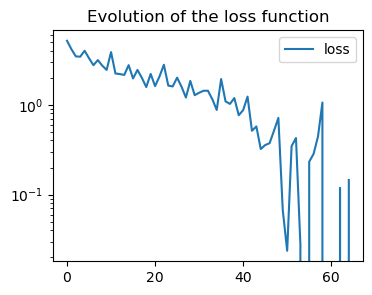

In [7]:
NB_EPOCH = 65
param_dim = len(param_label)
nb_transforms = 3
nb_layers = 5
hidden_features = 100
gnpe.set_nn(nb_transforms, nb_layers, hidden_features)
training_loss = gnpe.train_nn(NB_EPOCH, show_plot=True, save_fig=False, save_path='loss_curve_2.png')


## Inference on real data
We can now infer the parameters on two observing blocks.

It is important to make the histograms of the same shape as the ones in the training dataset.

Once the data preprocess, the inference is done with GRIP.
Then a corner plot can be made

dataset/UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5


/mnt/96980F95980F72D3/python_envs/envs/env_ml/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (65536) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


dataset/UT2015-02-08_ID010_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5


/mnt/96980F95980F72D3/python_envs/envs/env_ml/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (65536) than draws (1). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


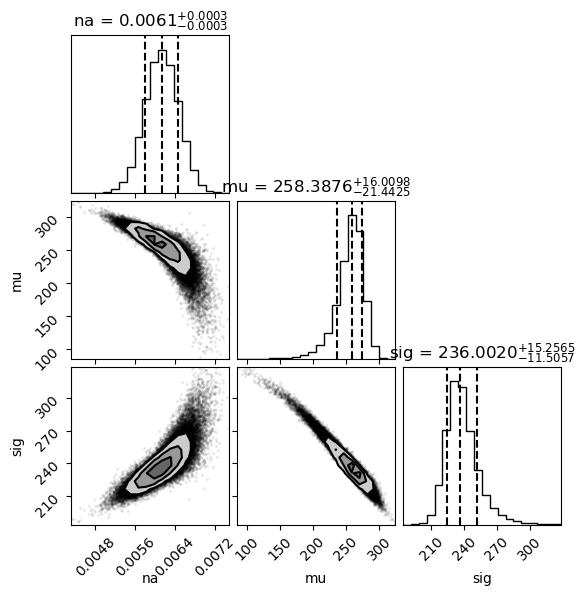

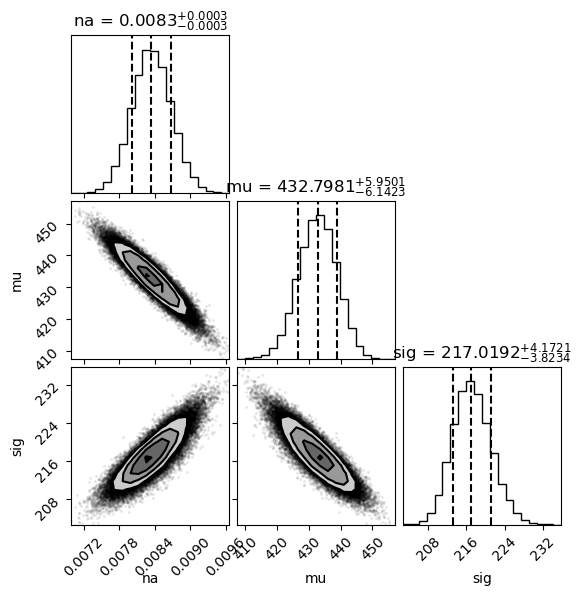

In [12]:
data_list = [datafolder+'UT2015-02-08_ID009_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5', datafolder+'UT2015-02-08_ID010_SCI_bet_Leo_DIT-60ms_11um_NULL.hdf5']

for elt in data_list:
    data = grip.load_data([elt], ['wl_scale', 'Iminus1', 'p1', 'p2', 'piston_rms'], (wl_min, wl_max), 'hdf5')
    Iminus = data['Iminus1']
    data_IA, data_IB = data['p1'], data['p2']
    Iplus = data_IA + data_IB + 2 * (data_IA * data_IB)**0.5
    data_null = Iminus / Iplus    
    null_axis, null_pdf, null_pdf_err, sz = grip.compute_data_histogram(data_null, \
                                                              bin_bounds, \
                                               wl_scale, normed=normed, nb_bins=N_BINS)

    samples = gnpe.inference_on_data(null_pdf, 2**16) # Inference

    fig = plt.figure(figsize=(6, 6))
    corner.corner(samples,
                  labels=['na', 'mu', 'sig'],
                  show_titles=True,
                  quantiles=[0.16, 0.5, 0.84],
                  fill_contours=True,
                  title_fmt='.4f',
                  fig=fig)     

## Conclusion
We now know how to use the NPE!
Notice the benefits of the amortization of the NPE: training one time, use for several inference.

## Remarks
Because we have initialised the class with some measured distributions (for the photometry and the thermal background), 
the simulated dataset will rely on this measurements.
The NN will only work to the observing blocks on the star used for the training set.
If we use this normalising flow on the dataset of another star, the inference may not be reliable.